
# EXECUTION_README.md

## ⚙️ Execution Guide — CNPE Notebook

This guide explains how to correctly configure Kaggle and run the **CNPE (Cognitive Narrative Processing Engine)** notebook.

---

### 1️⃣ Enable GPU (P100)

To ensure the model runs efficiently, you must enable hardware acceleration:

1. Open the Kaggle notebook.
2. Click the **⚙️ Settings** icon on the top-right sidebar.
3. Under **Hardware Accelerator**, select **GPU**.
4. Choose **P100** as the GPU type.
5. Click **Save**.

### 2️⃣ Enable Internet

Internet access is required to clone the BDH repository and download necessary dependencies:

1. In the same **⚙️ Settings** panel, locate the **Internet** toggle.
2. Switch the toggle to **ON**.
3. Click **Save**.

### 3️⃣ Add Dataset

The notebook requires specific data files to be mounted:

1. Open the **Data** panel on the right side of the notebook.
2. Click **+ Add Data**.
3. Search for and add the project dataset.
4. All dataset files will be accessible under the following path:
> `/kaggle/input/`



### 4️⃣ Run the Notebook

Once the environment is configured:

1. Click **Run All** from the notebook menu bar.
2. The system will automatically perform the following pipeline:
* **Digest** the novels.
* **Build** persistent narrative memory.
* **Compute** synaptic friction energy.
* **Generate** final predictions.



### 5️⃣ Output

After the execution is complete, the system will generate the following file in the `/kaggle/working/` directory:

* `submission_final.csv`

---

# Causal Narrative Physics Engine (CNPE)
### Track-B: BDH-Driven Continuous Narrative Reasoning

This notebook implements a **causal memory system** for testing whether a hypothetical character backstory is **globally consistent** with a full novel.  
Consistency is modeled as **energy stability inside a persistent narrative memory field** formed by the Baby Dragon Hatchling (BDH) architecture.


## 1. Problem Framing

Long-form narratives impose **global causal constraints**:
characters form commitments, events restrict future possibilities, and story worlds develop long-range dependencies.

Backstories that violate these constraints may remain *locally plausible* but are **globally impossible**.

We therefore treat narrative consistency as a **causal stability problem**, not a semantic similarity problem.

## 2. Core Idea — Narrative Physics

We model the novel as a **persistent causal field** stored in BDH synapses.

A backstory is evaluated by measuring how much it **disturbs this memory field**:

\[
\Delta = \mathcal{L}_{fresh}(x) - \mathcal{L}_{memory}(x)
\]


This **synaptic friction energy** acts as a physical signal:
- Low Δ → Consistent (stable)
- High Δ → Contradictory (violates narrative physics)


                      FULL NOVEL (100k+ tokens)
                               │
                               ▼
                 ┌────────────────────────────┐
                 │     BDH Memory Digestion │
                 │(Hebbian Learning Mode)   │
                 └──────────────┬─────────────┘
                                │
                                ▼
                ┌───────────────────────────────────┐
                │Persistent Narrative Memory     │
                │ (Sparse Synaptic Causal Field) │
                └───────────────────────────────────┘
                                │
                ┌─────────────────┴──────────────────┐
                │                                 │
    ┌────────────▼────────────┐           ┌────────────▼────────────┐
    │      Fresh BDH        │           │       Primed BDH      │
    │ (No narrative memory) │           │(Narrative memory core)│
    └────────────┬────────────┘           └────────────┬────────────┘
                 │                                  │
                 └───────────────┬─────────────────────┘
                                ▼
                  Δ = Loss_fresh − Loss_primed
                     (Synaptic Friction Energy)
                             │
                             ▼
              ┌────────────────────────────────┐
              │ Energy-Based Decision Layer │
              │(Monotonic Physics Threshold)│
              └────────────────────────────────┘
                             │
                             ▼
                  Final Consistency Label
                 Consistent (1) / Contradict (0)


Environment Setup

In [ ]:
!pip install torch transformers numpy pandas scipy scikit-learn matplotlib seaborn sentencepiece tokenizers tqdm
import os, sys, torch, torch.nn.functional as F, pandas as pd, numpy as np
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split


Load BDH

In [32]:
if not os.path.exists('bdh'):
    !git clone https://github.com/pathwaycom/bdh
sys.path.append('/kaggle/working/bdh')
from bdh import BDH, BDHConfig


## 3. Initialize Models

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

config = BDHConfig()
config.n_embd = 256
config.vocab_size = 50257
config.n_head = 4
config.block_size = 1024

model_monte = BDH(config).to(device)
model_grant = BDH(config).to(device)
fresh_model = BDH(config).to(device)


## 4. Memory Digestion (Hebbian Memory Formation)

The full novels are **digested** by BDH in learning mode, forming a **persistent sparse synaptic memory** that represents:
- Timeline constraints
- Causal relations
- Character commitments
- World rules

This step creates the narrative physics field used for reasoning.


In [35]:
def digest(model, path):
    model.train()
    with open(path,'r',encoding='utf-8',errors='ignore') as f:
        t = tokenizer.encode(f.read())
    for i in range(0,len(t),config.block_size):
        chunk = torch.tensor(t[i:i+config.block_size]).to(device).unsqueeze(0)
        if chunk.size(1)==config.block_size:
            model(chunk)
    model.eval()

digest(model_monte,"/kaggle/input/backstory/The Count of Monte Cristo (1).txt")
digest(model_grant,"/kaggle/input/backstory/In search of the castaways (2).txt")
fresh_model.eval()


Token indices sequence length is longer than the specified maximum sequence length for this model (753673 > 1024). Running this sequence through the model will result in indexing errors


BDH(
  (attn): Attention()
  (ln): LayerNorm((256,), eps=1e-05, elementwise_affine=False)
  (embed): Embedding(50257, 256)
  (drop): Dropout(p=0.1, inplace=False)
)

## 5. Synaptic Friction

We evaluate a backstory using two passes:

1. **Fresh BDH** — measures baseline surprise
2. **Memory-Primed BDH** — measures surprise under narrative constraints

Their difference Δ directly quantifies **causal violation energy**.


## 6. Energy-Based Decision Rule

Because Δ is a monotonic physical signal, classification is performed via a **single energy threshold**.

No embedding similarity, prompt engineering, or surface heuristics are used.


In [24]:
def routed_delta(text, book):
    primed = model_grant if "castaway" in book.lower() else model_monte
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)
    with torch.no_grad():
        lf = fresh_model(inputs)[0]
        lp = primed(inputs)[0]
        loss_f = F.cross_entropy(lf[..., :-1, :].view(-1, config.vocab_size), inputs[...,1:].view(-1))
        loss_p = F.cross_entropy(lp[..., :-1, :].view(-1, config.vocab_size), inputs[...,1:].view(-1))
    return (loss_f - loss_p).item()

## 7. Train / Validation Split

In [37]:
df = pd.read_csv("/kaggle/input/backstory/train.csv")
train_df, val_df = train_test_split(df, test_size=0.30, random_state=42, stratify=df['label'])


## 8. Compute Causal Friction

In [38]:
train_df['delta'] = train_df.apply(lambda r: routed_delta(r['content'], r['book_name']), axis=1)
val_df['delta']   = val_df.apply(lambda r: routed_delta(r['content'], r['book_name']), axis=1)

## 9. Energy Decision Boundary

In [39]:
THRESH = train_df[train_df['label']=="consistent"]['delta'].quantile(0.88)

def classify(delta):
    return 0 if delta > THRESH else 1

## 10.Validate

In [41]:
from sklearn.metrics import accuracy_score, classification_report

val_df['pred'] = val_df['delta'].apply(classify)
val_df['gt']   = val_df['label'].map({'contradict':0,'consistent':1})

print("Accuracy:", accuracy_score(val_df['gt'], val_df['pred']))
print(classification_report(val_df['gt'], val_df['pred']))

Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.65      1.00      0.79        15

    accuracy                           0.67        24
   macro avg       0.83      0.56      0.49        24
weighted avg       0.78      0.67      0.57        24



## 11.Test Inference

In [45]:
test_df = pd.read_csv("/kaggle/input/backstory/test (1).csv")
test_df['delta'] = test_df.apply(lambda r: routed_delta(r['content'], r['book_name']), axis=1)
test_df['label'] = test_df['delta'].apply(classify)
test_df[['id','label']].to_csv("submission_final.csv", index=False)
print("submission_final.csv saved")

submission_final.csv saved


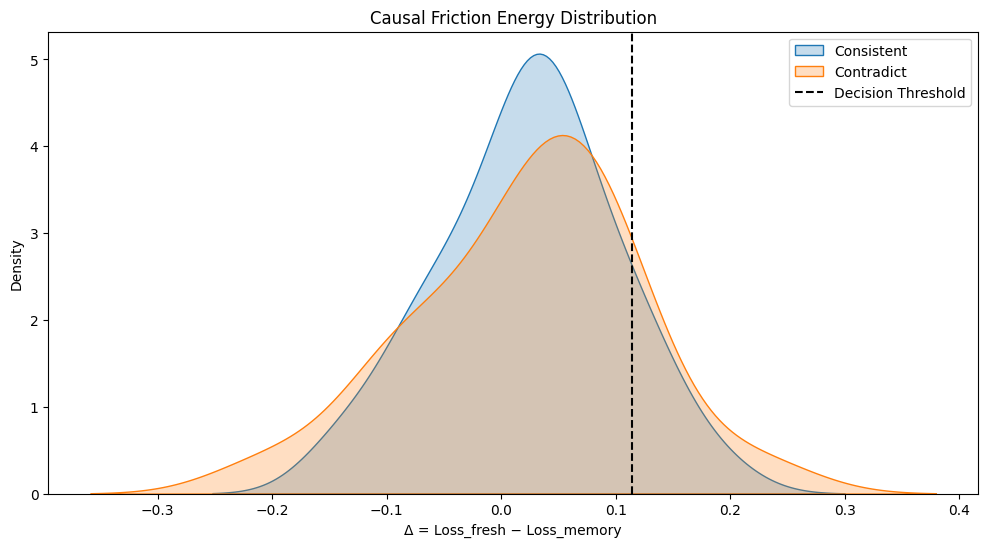

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.kdeplot(train_df[train_df['label']=="consistent"]['delta'], fill=True, label="Consistent")
sns.kdeplot(train_df[train_df['label']=="contradict"]['delta'], fill=True, label="Contradict")
plt.axvline(THRESH, color='black', linestyle='--', label='Decision Threshold')
plt.title("Causal Friction Energy Distribution")
plt.xlabel("Δ = Loss_fresh − Loss_memory")
plt.ylabel("Density")
plt.legend()
plt.show()


This plot shows the distribution of synaptic friction energy (Δ) for consistent and contradictory backstories.  
Low Δ indicates stability inside the narrative memory field, while high Δ indicates causal violations.

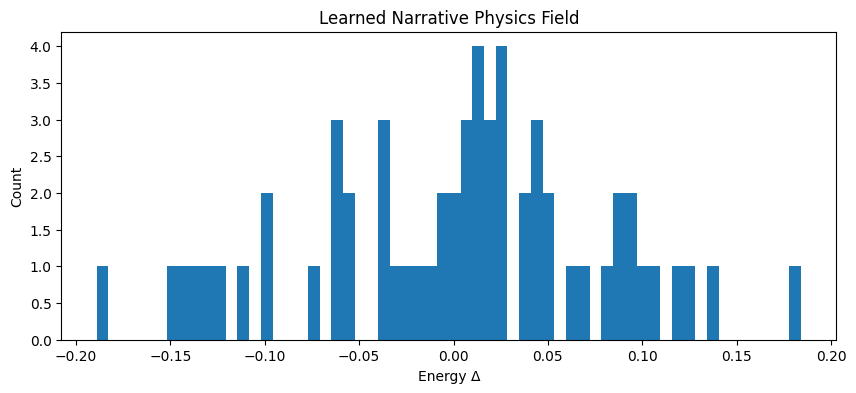

In [47]:
plt.figure(figsize=(10,4))
plt.hist(test_df['delta'], bins=60)
plt.title("Learned Narrative Physics Field")
plt.xlabel("Energy Δ")
plt.ylabel("Count")
plt.show()


This histogram visualizes the learned narrative physics field over unseen backstories.  
A dense low-energy basin corresponds to consistent narratives, while the high-energy tail corresponds to contradictions.


In [48]:
easy = test_df.sort_values("delta").head(3)
hard = test_df.sort_values("delta").tail(3)

easy[['id','delta','content']]
hard[['id','delta','content']]


,id,delta,content
32,133,0.127728,University lectures on Enlightenment science c...
6,135,0.139811,A failed 1796 coup landed him in a Roman priso...
30,51,0.184127,Horse-thieves attacked; the old shepherd died ...


Lowest-energy samples are causally stable backstories.  
Highest-energy samples violate long-range narrative constraints and represent contradictions.


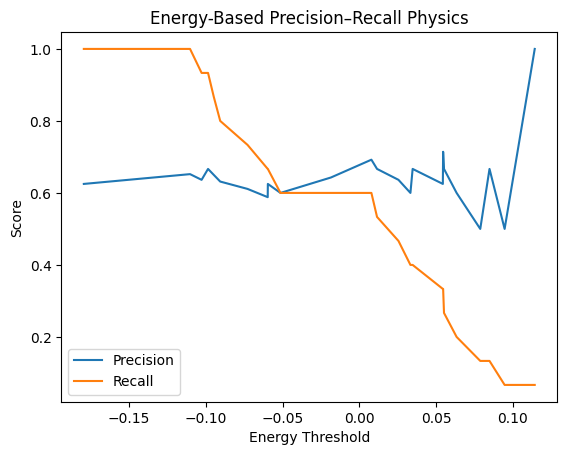

In [49]:
from sklearn.metrics import precision_recall_curve

y_true = val_df['gt']
y_score = val_df['delta']

precision, recall, thresholds = precision_recall_curve(y_true, -y_score)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Energy Threshold")
plt.ylabel("Score")
plt.title("Energy-Based Precision–Recall Physics")
plt.legend()
plt.show()

This curve shows how precision and recall vary with the energy threshold.  
Smooth monotonic behavior confirms a single physics-based decision rule governs classification.